In [1]:
#importing the necessary packages
suppressWarnings(suppressMessages(library("kernlab")))
suppressWarnings(suppressMessages(library("caret")))
suppressWarnings(suppressMessages(library(kknn)))
suppressWarnings(suppressMessages(library(pROC)))

In [2]:
#reading the data from text file
data <- read.table("./credit_card_data-headers.txt", header = TRUE)

In [3]:
head(data)

A1,A2,A3,A8,A9,A10,A11,A12,A14,A15,R1
1,30.83,0.000,1.25,1,0,1,1,202,0,1
0,58.67,4.460,3.04,1,0,6,1,43,560,1
0,24.50,0.500,1.50,1,1,0,1,280,824,1
1,27.83,1.540,3.75,1,0,5,0,100,3,1
1,20.17,5.625,1.71,1,1,0,1,120,0,1
1,32.08,4.000,2.50,1,1,0,0,360,0,1


In [4]:
#converting A1, A9, A10, A12 and R1 to factors since they are categorical variables.

#columns to be converted to factor
cols <- c("A1", "A9", "A10", "A12", "R1")
data[cols] <- lapply(data[cols], factor)

In [5]:
# 80% of the data is reserved for training -- which will eventually be split into 10 parts to perform cross validation.
# remaining 20% is used for testing -- evaluating the performance of best model selected.
set.seed(42)
smp_size <- floor(0.8 * nrow(data))

train_ind <- sample(seq_len(nrow(data)), size = smp_size)
train <- data[train_ind, ]
test <- data[-train_ind, ]

knn <- train.kknn(R1 ~., data = train, kmax = 15, distance = 2, 
               kernel = c("triangular", "rectangular", "epanechnikov", "optimal"),
               scale = TRUE)

knn$best.parameters

$kernel
[1] "rectangular"

$k
[1] 7

In [6]:
best_val_accuracy <- (1-knn$MISCLASS)[knn$best.parameters$k, knn$best.parameters$kernel]
best_val_accuracy

[1] 0.8508604

In [7]:
#evaluating the best selected model on test data
test_accuracy <- sum(predict(knn, test) == test[,"R1"]) / nrow(test)
test_accuracy

[1] 0.8549618

Note -- I do understand that my test accuracy is greater than validation accuracy -- but this is due to the random effect discussed in lectures. If i change the seed, I get different results and hence I believe that it isn't something wrong

In [8]:
#exercise 3.1b

#splitting the data into train, test and validation

spec = c(train = .6, test = .2, validate = .2)

g = sample(cut(
  seq(nrow(data)), 
  nrow(data)*cumsum(c(0,spec)),
  labels = names(spec)
))

res = split(data, g)

In [9]:
train <- res$train
validate <- res$validate
test <- res$test

for (k in 1:10){
    pred <- c()
    for (i in 1:nrow(validate)){
        knn <- kknn(R1 ~ .,train = train, test = validate[i, ], k = k, distance = 2, kernel = "rectangular", scale=TRUE)
        pred <- c(pred, knn$fitted.values)
    }
    pred <- pred-1
    accuracy <- sum(pred == validate[,11]) / nrow(validate)
    cat("\n For K = ", k, "validation accuracy = ", accuracy, "\n")       
}



 For K =  1 validation accuracy =  0.7709924 

 For K =  2 validation accuracy =  0.7709924 

 For K =  3 validation accuracy =  0.8091603 

 For K =  4 validation accuracy =  0.8091603 

 For K =  5 validation accuracy =  0.8320611 

 For K =  6 validation accuracy =  0.8320611 

 For K =  7 validation accuracy =  0.8167939 

 For K =  8 validation accuracy =  0.8167939 

 For K =  9 validation accuracy =  0.8320611 

 For K =  10 validation accuracy =  0.8320611 


It can be seen that the best model has K = 9

In [10]:
#evaluating the test accuracy
pred <- c()
for (i in 1:nrow(test)){
    knn <- kknn(R1 ~ .,train = train, test = test[i, ], k = 9, distance = 2, kernel = "rectangular", scale=TRUE)
    pred <- c(pred, knn$fitted.values)
    }
pred <- pred-1
accuracy <- sum(pred == test[,11]) / nrow(test)
cat("\n For K = ", k, "test accuracy = ", accuracy, "\n")



 For K =  10 test accuracy =  0.8396947 


The test accuracy is 0.8396947

Exercise 4.1

I work as a data scientist at a small business lending firm. Using past data, we decide on who should be granted a loan. However, we cannot say anything about those who were rejected. This is called as rejection inference. Hence, we use clustering to group the rejected applicants and find some pattern that could help us improve our decision making process. Features used are FICO, Time in business, Industry Risk (we have classified major industries into three categories -- High Risk, Medium Risk and Low Risk), Annual Revenue, Profit($)

In [11]:
library(datasets)

In [12]:
str(iris)

'data.frame':	150 obs. of  5 variables:
 $ Sepal.Length: num  5.1 4.9 4.7 4.6 5 5.4 4.6 5 4.4 4.9 ...
 $ Sepal.Width : num  3.5 3 3.2 3.1 3.6 3.9 3.4 3.4 2.9 3.1 ...
 $ Petal.Length: num  1.4 1.4 1.3 1.5 1.4 1.7 1.4 1.5 1.4 1.5 ...
 $ Petal.Width : num  0.2 0.2 0.2 0.2 0.2 0.4 0.3 0.2 0.2 0.1 ...
 $ Species     : Factor w/ 3 levels "setosa","versicolor",..: 1 1 1 1 1 1 1 1 1 1 ...


In [13]:
#we don't need the response variable -- since it is an unsupervised task
iris.new<- iris[,c(1,2,3,4)]
iris.class<- iris[,"Species"]
head(iris.new)

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
5.1,3.5,1.4,0.2
4.9,3.0,1.4,0.2
4.7,3.2,1.3,0.2
4.6,3.1,1.5,0.2
5.0,3.6,1.4,0.2
5.4,3.9,1.7,0.4


In [14]:
normalize <- function(x){
  return ((x-min(x))/(max(x)-min(x)))
}

In [15]:
iris.new$Sepal.Length<- normalize(iris.new$Sepal.Length)
iris.new$Sepal.Width<- normalize(iris.new$Sepal.Width)
iris.new$Petal.Length<- normalize(iris.new$Petal.Length)
iris.new$Petal.Width<- normalize(iris.new$Petal.Width)
head(iris.new)

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
0.22222222,0.6250000,0.06779661,0.04166667
0.16666667,0.4166667,0.06779661,0.04166667
0.11111111,0.5000000,0.05084746,0.04166667
0.08333333,0.4583333,0.08474576,0.04166667
0.19444444,0.6666667,0.06779661,0.04166667
0.30555556,0.7916667,0.11864407,0.12500000


In [16]:
set.seed(42)
irisCluster<- kmeans(iris.new,3, nstart = 20) 

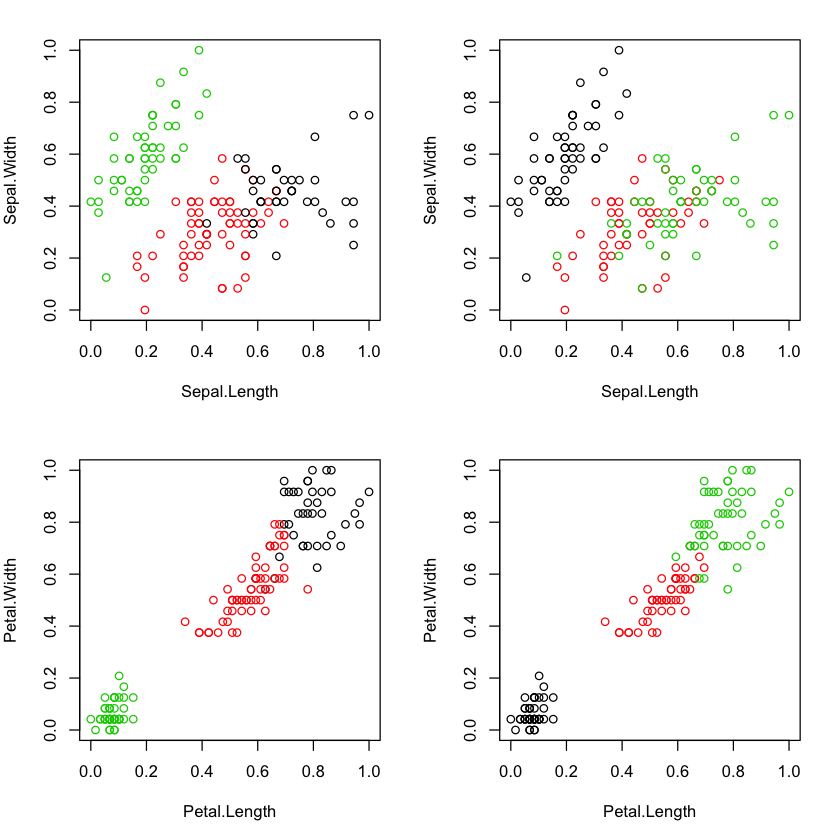

In [17]:
par(mfrow=c(2,2), mar=c(5,4,2,2))
plot(iris.new[c(1,2)], col=irisCluster$cluster)
plot(iris.new[c(1,2)], col=iris.class)
plot(iris.new[c(3,4)], col=irisCluster$cluster)
plot(iris.new[c(3,4)], col=iris.class)

In [18]:
table(irisCluster$cluster,iris.class)

   iris.class
    setosa versicolor virginica
  1      0          3        36
  2      0         47        14
  3     50          0         0

In [19]:
k.max <- 10
wss<- sapply(1:k.max,function(k){kmeans(iris.new,k,nstart = 20,iter.max = 20)$tot.withinss})
wss

[1] 41.166110 12.127791  6.982216  5.516933  4.580323  3.923095  3.468937
 [8]  3.128259  2.801430  2.590471

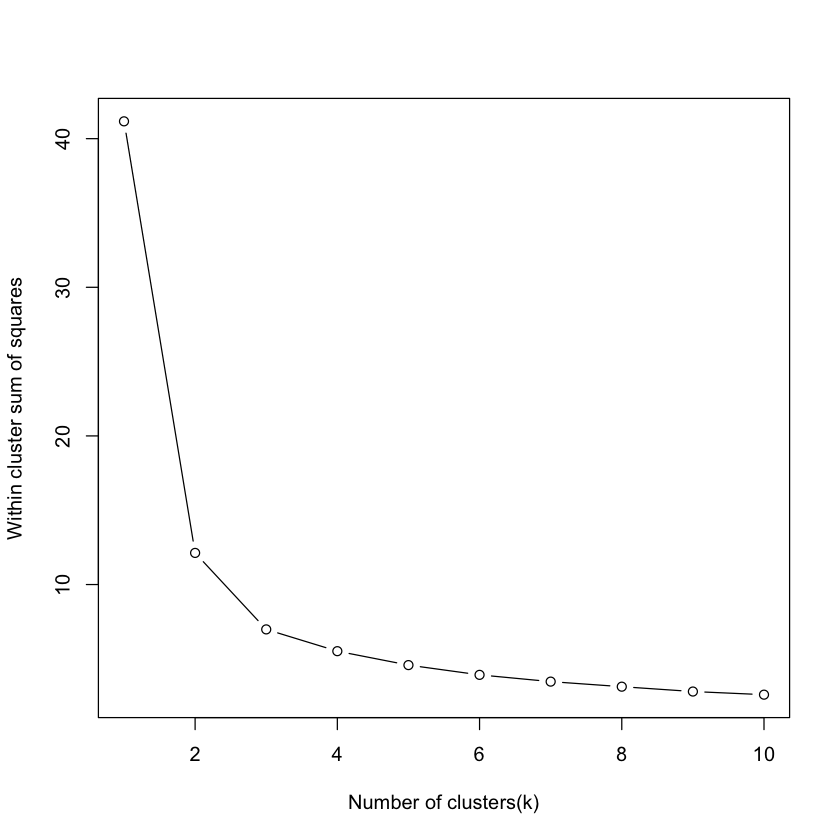

In [20]:
plot(1:k.max,wss, type= "b", xlab = "Number of clusters(k)", ylab = "Within cluster sum of squares")

In [21]:
#it can clearly be seen that 3 is the correct number of clusters.